# Pipeline #1: Clustering

This pipeline does the following:
- Visualization of the datasets
- Preparation of the inputs for running the SuStaIn algorithm
- Launching of the algorithm
- Model stability tracking
- 

#### Load the library that will be used

In [53]:
# Load libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
import wandb
from sklearn.metrics.cluster import adjusted_rand_score


output_folder = "/Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/results/"
input_folder = "/Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/data/"



#### Load the dataset (input 'copn' or 'ppmi')

In [21]:
dataset = input()
print("Selected dataset:", dataset)

data_path = ""
if dataset == "copn":
    data_path = input_folder + "dataset_1_copn/data.xlsx"
elif dataset == "ppmi":
    data_path = input_folder + "dataset_2_ppmi/data.xlsx"

# prob_nl
prob_nl = pd.read_excel(data_path, sheet_name="1_prob_nl").values
print("prob_nl:")
print("shape:", prob_nl.shape)
print(prob_nl)

# prob_score
tmp = pd.read_excel(data_path, sheet_name="2_prob_score").values
original_shape = tmp.shape
print(original_shape)

desired_shape = (prob_nl.shape[0], 26, 4)
prob_score = tmp.reshape(desired_shape)
print("prob_score:")
print("shape:", prob_score.shape)
print(prob_score)

# score_vals
score_vals = pd.read_excel(data_path, sheet_name="3_score_vals").values
print("score_vals")
print("shape:", score_vals.shape)
print(score_vals)


Selected dataset: copn
prob_nl:
shape: (956, 26)
[[0.752 0.851 0.741 ... 0.885 0.93  0.874]
 [0.752 0.851 0.065 ... 0.029 0.017 0.874]
 [0.062 0.037 0.065 ... 0.029 0.017 0.031]
 ...
 [0.062 0.851 0.065 ... 0.029 0.017 0.031]
 [0.752 0.851 0.065 ... 0.029 0.93  0.874]
 [0.752 0.851 0.741 ... 0.029 0.017 0.031]]
(24856, 4)
prob_score:
shape: (956, 26, 4)
[[[0.06198765 0.06198765 0.06198765 0.06198765]
  [0.0371787  0.0371787  0.0371787  0.0371787 ]
  [0.0648523  0.0648523  0.0648523  0.0648523 ]
  ...
  [0.02875    0.02875    0.02875    0.02875   ]
  [0.0174964  0.0174964  0.0174964  0.0174964 ]
  [0.0314284  0.0314284  0.0314284  0.0314284 ]]

 [[0.06198765 0.06198765 0.06198765 0.06198765]
  [0.0371787  0.0371787  0.0371787  0.0371787 ]
  [0.7405908  0.0648523  0.0648523  0.0648523 ]
  ...
  [0.885      0.02875    0.02875    0.02875   ]
  [0.0174964  0.9300144  0.0174964  0.0174964 ]
  [0.0314284  0.0314284  0.0314284  0.0314284 ]]

 [[0.06198765 0.06198765 0.7520494  0.06198765]
  [0

In [ ]:
pheno.columns
# Let's start by having a quick look at the `summary statistics` and `distribution` of `Age`:
print(pheno['Age'].describe())

# simple histogram with seaborn
sns.distplot(pheno['Age'],
            #bins=30,          # increase "resolution"
            #color='black',    # change color
            #kde=False,        # get rid of KDE (y axis=N)
            #rug=True,         # add "rug"
            )

import numpy as np

log_age = np.log(pheno['Age'])
sns.distplot(log_age,
            bins=30,          
            color='black',    
            kde=False,         
            rug=True,          
            )

#### Set n_s_max: models with 1 to n_s_max clusters will be fit

In [37]:
n_s_max = input()
print("Max number of clusters was set to:", n_s_max)


Max number of clusters was set to: 6


#### Set n_iterations: number of MCMC iterations 

In [38]:
n_iterations = input()
print("Number of MCMC iterations was set to:", n_iterations)

Number of MCMC iterations was set to: 100000


In [39]:
# output_no = random.randint(100, 999)
output_no = 532

output_path = output_folder + str(output_no)
seed = 5

biomarkers = ['Cognition', 'Psychosis', 'Depression', 'Anxiety', 'Apathy',
            'Impulsivity', 'Insomnia', 'Sleepiness', 'Pain', 'Incontinence',
            'Constipation', 'Dizziness', 'Fatigue', 'Speech', 'Drooling',
            'Swallowing', 'Eating', 'Dressing', 'Hygiene', 'Handwriting', 'Hobbies',
            'Rolling', 'Tremor', 'Arising', 'Walking', 'Freezing']

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Brainhack pySuStaIn",

    # track hyperparameters and run metadata
    config={
    "dataset": dataset,
    "output_no": output_no,
    "n_s_max": n_s_max,
    "n_iterations": n_iterations,
    "seed": seed
    }
)

# create folder for results if it doesn't exist already
if not os.path.isdir(output_path):
    os.makedirs(output_path)

# The initializer for the scored events model implementation of AbstractSustain
#         Parameters:
#           prob_nl                     - probability of negative/normal class for all subjects across all biomarkers 
#                                         dim: number of subjects x number of biomarkers
        
#           prob_score                  - probability of each score for all subjects across all biomarkers
#                                         dim: number of subjects x number of biomarkers x number of scores
#           score_vals                  - a matrix specifying the scores for each biomarker
#                                         dim: number of biomarkers x number of scores
#           biomarker_labels            - the names of the biomarkers as a list of strings
#           N_startpoints               - number of startpoints to use in maximum likelihood step of SuStaIn, typically 25
#           N_S_max                     - maximum number of subtypes, should be 1 or more
#           N_iterations_MCMC           - number of MCMC iterations, typically 1e5 or 1e6 but can be lower for debugging
#           output_folder               - where to save pickle files, etc.
#           dataset_name                - for naming pickle files
#           use_parallel_startpoints    - boolean for whether or not to parallelize the maximum likelihood loop
#           seed                        - random number seed

sustain_input_zscore = pySuStaIn.OrdinalSustain(
                            prob_nl,     
                            prob_score,      
                            score_vals,
                            biomarkers,
                            25,
                            int(n_s_max),
                            int(n_iterations), 
                            output_path, 
                            dataset, 
                            True,
                            seed)                      
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input_zscore.run_sustain_algorithm()

wandb.finish()

Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/results/532/pickle_files/copn_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/results/532/pickle_files/copn_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/results/532/pickle_files/copn_subtype2.pickle. Using pickled variables for 2 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/results/532/pickle_files/copn_subtype3.pickle. Using pickled variables for 3 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/song_project/brainhack_source/results/532/pickle_files/copn_subtype4.pickle. Using pickled variables for 4 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/

#### Generate result file

In [ ]:
n_subtypes = 3
pickle_filename_s = output_folder + '/pickle_files/' + 'copn_subtype' + str(n_subtypes) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

results = data_to_print
# print(data_to_print.shape)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    print(variable)
    
    # add SuStaIn output to dataframe
    results.loc[:,variable] = pk[variable] 

# write results to excel file
writer = pd.ExcelWriter("/Users/song/Documents/dev/repos/07. pySuStaIn COP-N/results/ordinal/o2/o2.xlsx", engine='openpyxl', mode='a', if_sheet_exists = 'replace')
results.to_excel(writer, sheet_name = "4st")
writer.close()

#### Evaluate the stability of model using the Adjust Rand Index (ARI)

The ARI is a measure of the similarity between two data clusterings. The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The raw RI score is then “adjusted for chance” into the ARI score.

Input # of two models to be compared

In [55]:
def get_excel_path(no_model):
    return output_folder + str(no_model) + "/" + str(no_model) + ".xlsx"

def get_input_model(no_model):
    return pd.read_excel(get_excel_path(no_model), sheet_name="stability")["Stab"].tolist()

no_model_1 = input()
no_model_2 = input()

print("First model: #", no_model_1)
print("Second model: #", no_model_2)

inputs_model_1 = get_input_model(no_model_1)
inputs_model_2 = get_input_model(no_model_2)
print(inputs_model_1)
print(inputs_model_2)

adjusted_rand_score(inputs_model_1, inputs_model_2)






First model: # 532
Second model: # 841
[0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 2, 2, 0, 0, 0, 2, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 

0.1443848207063997

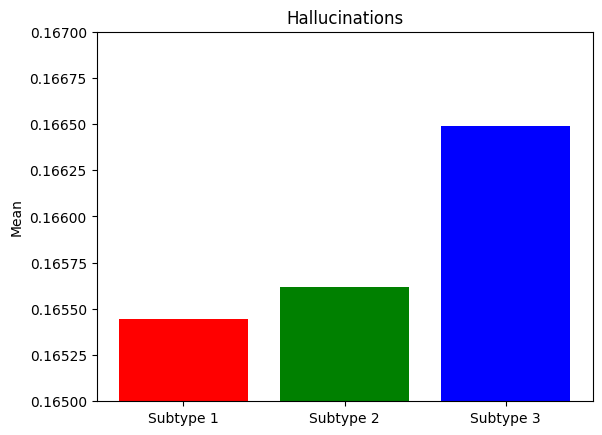

In [60]:
import matplotlib.pyplot as plt

# Data
categories = ['Subtype 1', 'Subtype 2', 'Subtype 3']
values = [0.165445026, 0.165618449, 0.166491043]

# Plotting
fig, ax = plt.subplots()
ax.bar(categories, values, color=['red', 'green', 'blue'])

# Adding labels and title
ax.set_ylabel('Mean')
ax.set_title('Hallucinations')
ax.set_ylim(0.165, 0.167)

plt.show()